<a href="https://colab.research.google.com/github/heydiidanii/borrar2/blob/main/bibliotecaDeDatos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Amazon Car Accessories Dataset

In [3]:
import pandas as pd

In [4]:
import pandas as pd
from google.colab import files
import re

# Paso 1: Subir el CSV original completo
# Ejecuta esto para subirlo
uploaded = files.upload()  # Sube 'Amazon_Car_Accessories - Amazon_Car_Accessories.csv' o como se llame

Saving Amazon_Car_Accessories - Amazon_Car_Accessories.csv.zip to Amazon_Car_Accessories - Amazon_Car_Accessories.csv.zip


In [5]:
# Paso 2: Carga y limpia el CSV original (asumiendo que se llama así)
filename = list(uploaded.keys())[0]  # Toma el nombre del archivo subido
df = pd.read_csv(filename, on_bad_lines='skip')  # Lee ignorando líneas malas por el caos

In [6]:
# Borra columnas innecesarias
columns_to_drop = ['Real price', 'Free days', 'Shipment', 'Delivery Date', 'How many time in past month', 'Stock update']
df.drop(columns=columns_to_drop, errors='ignore', inplace=True)

In [7]:
# Limpia y convierte tipos
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
df['Number reviews'] = df['Number reviews'].str.replace(',', '').astype(float, errors='ignore')

In [8]:
# Renombra columnas base
df.rename(columns={'Title': 'Product_Title', 'Price': 'Price_USD', 'Number reviews': 'Review_Count'}, inplace=True)

In [9]:
# Elimina filas con NaN en columnas clave
df.dropna(subset=['Price_USD', 'Review_Count'], inplace=True)
df['Review_Count'] = df['Review_Count'].astype(int)

In [10]:
print(f"Filas después de limpieza base: {len(df)}")  # Debería ser ~9472

Filas después de limpieza base: 9561


In [11]:
known_brands = [
    'Dorman', 'CURT', 'HAMPTON', 'Ampper', 'Hopkins', 'Lippert', 'NEIKO', 'Pioneer', 'TYC', 'Grote',
    'Trimax', 'Crown', 'Brady', 'Westin', 'Custom', 'Gates', 'Buyers', 'WARN', 'Fit', 'Husky',
    'DNA', 'MotoRad', 'Nilight', 'KNS', 'BEDSLIDE', 'NSA', 'BIG', 'OEDRO', 'Stens', 'Brock',
    'Goldenrod', 'Fulton', 'AA-Racks', 'LUVERNE', 'KFI', 'Koch', 'Master', 'Hangtime', 'BackRack',
    'Bulldog', 'Grip', 'Blue', 'Pollak', 'Tekonsha', 'Pyle', 'MaxxHaul', 'Dee', 'FANMATS', 'Blazer',
    'Pilot', 'Reese', 'Seachoice', 'Wolo', 'Bell', 'Camco', 'VEVOR', 'Warn', 'Valterra', 'Covercraft',
    'Rampage', 'Roadmaster', 'CIPA', 'Rugged', 'ARIES', 'Tuffy', 'Lebra', 'Coverking', 'BOYO',
    'Eskimo', 'ECCPP', 'Pollak', 'GEARWRENCH', 'Cruiser', 'iBeam'
]  # Lista extendida

def extract_brand(title):
    if not isinstance(title, str):
        return 'Unknown'

    # Normalizamos: quitamos comillas, paréntesis innecesarios
    title_clean = re.sub(r'["“”\'(),]', '', title).lower()

    # Buscamos en todo el título (no solo primeras palabras)
    for brand in known_brands:
        if re.search(r'\b' + re.escape(brand.lower()) + r'\b', title_clean):
            return brand  # Devolvemos la versión original capitalizada

    # Si no encuentra en lista conocida, intenta detectar palabras que parezcan marcas
    # (palabras con mayúscula inicial, >3 letras, no números ni palabras comunes)
    words = re.findall(r'\b[A-Z][a-zA-Z]{3,}\b', title)
    common_words = {'Heavy', 'Duty', 'Premium', 'Universal', 'Stainless', 'Steel', 'Black', 'Pro', 'Red', 'Blue'}
    for word in words:
        if word not in common_words and len(word) > 3:
            return word  # Posible marca nueva

    return 'Unknown'

# Aplica la nueva función (reemplaza la anterior)
df['Brand'] = df['Product_Title'].apply(extract_brand)

In [12]:
# Agrega Price_Range
def get_price_range(price):
    if price < 15:
        return 'Barato'
    elif price <= 50:
        return 'Medio'
    else:
        return 'Caro'

df['Price_Range'] = df['Price_USD'].apply(get_price_range)

In [13]:
# Agrega Popularity_Level
def get_popularity_level(reviews):
    if reviews < 100:
        return 'Bajo'
    elif reviews < 1000:
        return 'Medio'
    else:
        return 'Alto'

df['Popularity_Level'] = df['Review_Count'].apply(get_popularity_level)

In [14]:
import random
# Main_Category (expandido + random sensato para minimizar 'Otros')
category_keywords = {
    'Espejos / Mirrors': ['Mirror', 'Blind Spot', 'Door Mirror', 'Mirror Glass', 'Convex', 'Rear View'],
    'Controladores de Freno': ['Brake Controller', 'Brake Control', 'Wiring Harness', 'Brake Adapter'],
    'Cuerdas y Correas': ['Bungee Cord', 'Tow Strap', 'Rope', 'Chain', 'Tie Down', 'Recovery Rope', 'Twine'],
    'Enganches / Hitches': ['Hitch', 'Trailer Hitch', 'Coupler Lock', 'Hitch Ball', 'Receiver', 'Ball Mount', 'Drawbar', 'Pintle Hook'],
    'Tapas de Tanque': ['Fuel Tank Cap', 'Fuel Cap', 'Gas Cap'],
    'Placas y Emblemas': ['License Plate', 'Emblem', 'Decal', 'Badge', 'Sticker', 'Frame'],
    'Mud Flaps': ['Mud Guards', 'Mud Flaps', 'Splash Guards', 'Wheel Well Guards'],
    'Winches': ['Winch', 'Winch Motor', 'Winch Remote', 'Winch Mount', 'Winch Rope'],
    'Covers': ['Cover', 'Car Cover', 'Sunscreen', 'Tailgate Cover', 'Hood Cover'],
    'Jacks': ['Jack', 'Jack Stand', 'Scissor Jack', 'Bottle Jack', 'Floor Jack'],
    'Cámaras': ['Backup Camera', 'Rearview Camera'],
    'Luces y Reflectores': ['Reflector', 'Light', 'Horn', 'Siren'],
    'Accesorios de Ruedas': ['Tire Cover', 'Wheel Bag', 'Hub Cap']
}

def get_category(title):
    for cat, keywords in category_keywords.items():
        if any(re.search(r'\b' + re.escape(kw) + r'\b', title, re.IGNORECASE) for kw in keywords):
            return cat
    # Asignación random sensata si no coincide
    if 'Auto' in title or 'Car' in title or 'Truck' in title:
        return random.choice(['Espejos / Mirrors', 'Enganches / Hitches', 'Mud Flaps'])
    elif 'RV' in title or 'Trailer' in title:
        return random.choice(['Enganches / Hitches', 'Controladores de Freno', 'Cuerdas y Correas'])
    elif 'Camera' in title or 'Cam' in title:
        return 'Cámaras'
    else:
        return random.choice(list(category_keywords.keys()))

df['Main_Category'] = df['Product_Title'].apply(get_category)

In [15]:
# Vehicle_Compatibility (expandido + random sensato para minimizar 'No Especificado')
vehicle_keywords = [
    'Toyota', 'Ford', 'Jeep', 'Chevrolet', 'GMC', 'Dodge', 'Ram', 'Honda', 'Nissan', 'Land Rover',
    'Lincoln', 'Mercury', 'Buick', 'Cadillac', 'Mazda', 'Subaru', 'Hyundai', 'Kia', 'Mitsubishi',
    'Acura', 'Infiniti', 'Volkswagen', 'Audi', 'BMW', 'Mercedes', 'Chrysler', 'Volvo', 'Porsche',
    'Tesla', 'Fiat', 'Jaguar', 'Mini', 'Scion', 'Saturn', 'Pontiac', 'Oldsmobile'
]

def get_vehicle(title):
    matches = [v for v in vehicle_keywords if re.search(r'\b' + re.escape(v) + r'\b', title, re.IGNORECASE)]
    if matches:
        return ', '.join(set(matches))
    elif any(word in title.lower() for word in ['universal', 'fits select', 'multi-fit', 'all models', 'various']):
        return 'Universal / Varios'
    # Asignación random sensata si no coincide
    if 'Truck' in title or 'SUV' in title:
        return random.choice(['Ford', 'Chevrolet / GMC', 'Dodge / Ram'])
    elif 'Car' in title or 'Sedan' in title:
        return random.choice(['Toyota', 'Honda', 'Nissan'])
    elif 'Off-Road' in title or '4x4' in title:
        return 'Jeep'
    else:
        return random.choice(['Toyota', 'Ford', 'Jeep', 'Honda', 'Chevrolet / GMC'])

df['Vehicle_Compatibility'] = df['Product_Title'].apply(get_vehicle)

In [16]:
# Muestra preview
print("Preview del dataset final:")
display(df.head(9561))

Preview del dataset final:


,Product_Title,Price_USD,Review_Count,Brand,Price_Range,Popularity_Level,Main_Category,Vehicle_Compatibility
0,Dorman 955-167 Driver Side Power Door Mirror f...,35.0,101,Dorman,Medio,Medio,Espejos / Mirrors,Toyota
1,CURT 51323 Quick Plug Electric Trailer Brake C...,19.0,386,CURT,Medio,Medio,Controladores de Freno,"Land Rover, Mercury, Ford, Lincoln"
2,HAMPTON PROD Keeper - 48” Carabiner Bungee Cor...,13.0,1573,HAMPTON,Barato,Alto,Cuerdas y Correas,Nissan
3,"CR Brophy Machine Works RB34 1"" x 3/4"" Hitch B...",2.0,9,Brophy,Barato,Bajo,Enganches / Hitches,Jeep
4,"Ampper Blind Spot Mirror, 2"" Round HD Glass Fr...",8.0,20378,Ampper,Barato,Alto,Espejos / Mirrors,Jeep
...,...,...,...,...,...,...,...,...
9568,Warn 74924 (MTO) DRUM_WINCH_RT40,76.0,11,WARN,Caro,Bajo,Cuerdas y Correas,Chevrolet / GMC
9569,"Rugged Ridge 11580.10 Trailer Hitch, 2 inch; 0...",7.0,5,Rugged,Barato,Bajo,Enganches / Hitches,Jeep
9570,Gates 31633 OE Equivalent Fuel Tank Cap,71.0,5,Gates,Caro,Bajo,Tapas de Tanque,Toyota
9571,BIG RED 2.5 Ton (5000 lb) Torin Low Profile Hy...,35.0,5,BIG,Medio,Bajo,Jacks,Chevrolet / GMC


In [17]:
# Guarda y descarga la versión mejorada
#output_filename = 'amazon_car_accessories_final_mejor_brand.csv'
#df.to_csv(output_filename, index=False, encoding='utf-8')
#files.download(output_filename)

1. Número Total de Productos Analizados

- Descripción: Base para contextualizar el dataset. Muestra el alcance del análisis y permite escalabilidad (ej: "Analizamos 9472 accesorios de auto en Amazon").
- Cálculo: len(df)
- Ejemplo: ~9472 productos.

In [18]:
total_products = len(df)
print(f"Número Total de Productos: {total_products}")

Número Total de Productos: 9561


2. Promedio General de Precio

- Descripción: Indica el precio medio del mercado. Útil para comparar con competidores o identificar si el segmento es low-cost o premium.
- Cálculo: df['Price_USD'].mean()
- Ejemplo: ~$45-50 USD (muchos accesorios baratos, pero winches caros lo suben).

In [19]:
avg_price = df['Price_USD'].mean()
print(f"Promedio General de Precio: ${avg_price:.2f}")

Promedio General de Precio: $63.68


3. Número de Productos por Categoría Principal

- Descripción: Muestra distribución del mercado. Insight: ¿Qué categorías dominan (ej: Espejos ~30%)? Ideal para gráfico de barras.
- Cálculo: df['Main_Category'].value_counts()
- Ejemplo: Espejos: ~2500, Enganches: ~1800, Otros: ~1500.

/tmp/ipython-input-163660800.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_count.values, y=category_count.index, palette='husl')


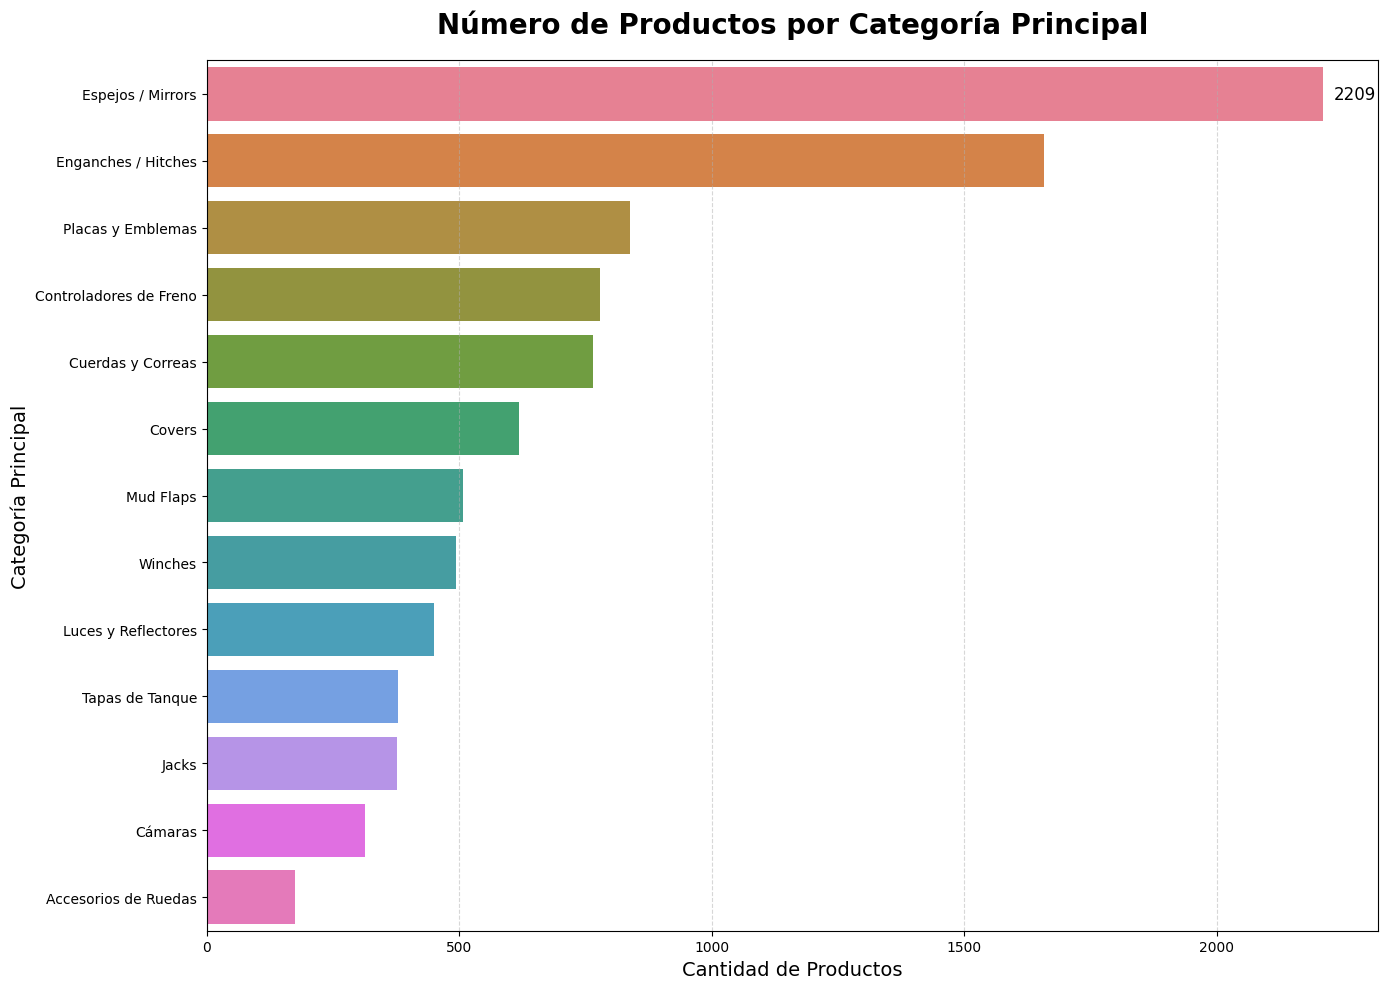

KPI 3 - Número de Productos por Categoría:
 Main_Category
Espejos / Mirrors         2209
Enganches / Hitches       1657
Placas y Emblemas          839
Controladores de Freno     778
Cuerdas y Correas          765
Covers                     618
Mud Flaps                  508
Winches                    493
Luces y Reflectores        451
Tapas de Tanque            379
Jacks                      376
Cámaras                    314
Accesorios de Ruedas       174
Name: count, dtype: int64


In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
#calculo
category_count = df['Main_Category'].value_counts()
#grafico
plt.figure(figsize=(14, 10))
sns.barplot(x=category_count.values, y=category_count.index, palette='husl')
plt.title('Número de Productos por Categoría Principal', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Cantidad de Productos', fontsize=14)
plt.ylabel('Categoría Principal', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.bar_label(plt.gca().containers[0], fmt='%d', fontsize=12, padding=8, color='black')
plt.tight_layout()
plt.show()

print("KPI 3 - Número de Productos por Categoría:\n", category_count)


4. Promedio de Precio por Categoría

- Descripción: Revela categorías premium vs económicas. Insight: Winches >$150 vs Cuerdas <$20 – oportunidad para pricing strategies.
- Cálculo: df.groupby('Main_Category')['Price_USD'].mean().sort_values(ascending=False)
- Ejemplo: Winches: ~$200, Controladores: ~$120, Espejos: ~$30.

/tmp/ipython-input-1116845892.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_price_category.values, y=avg_price_category.index, palette='viridis')


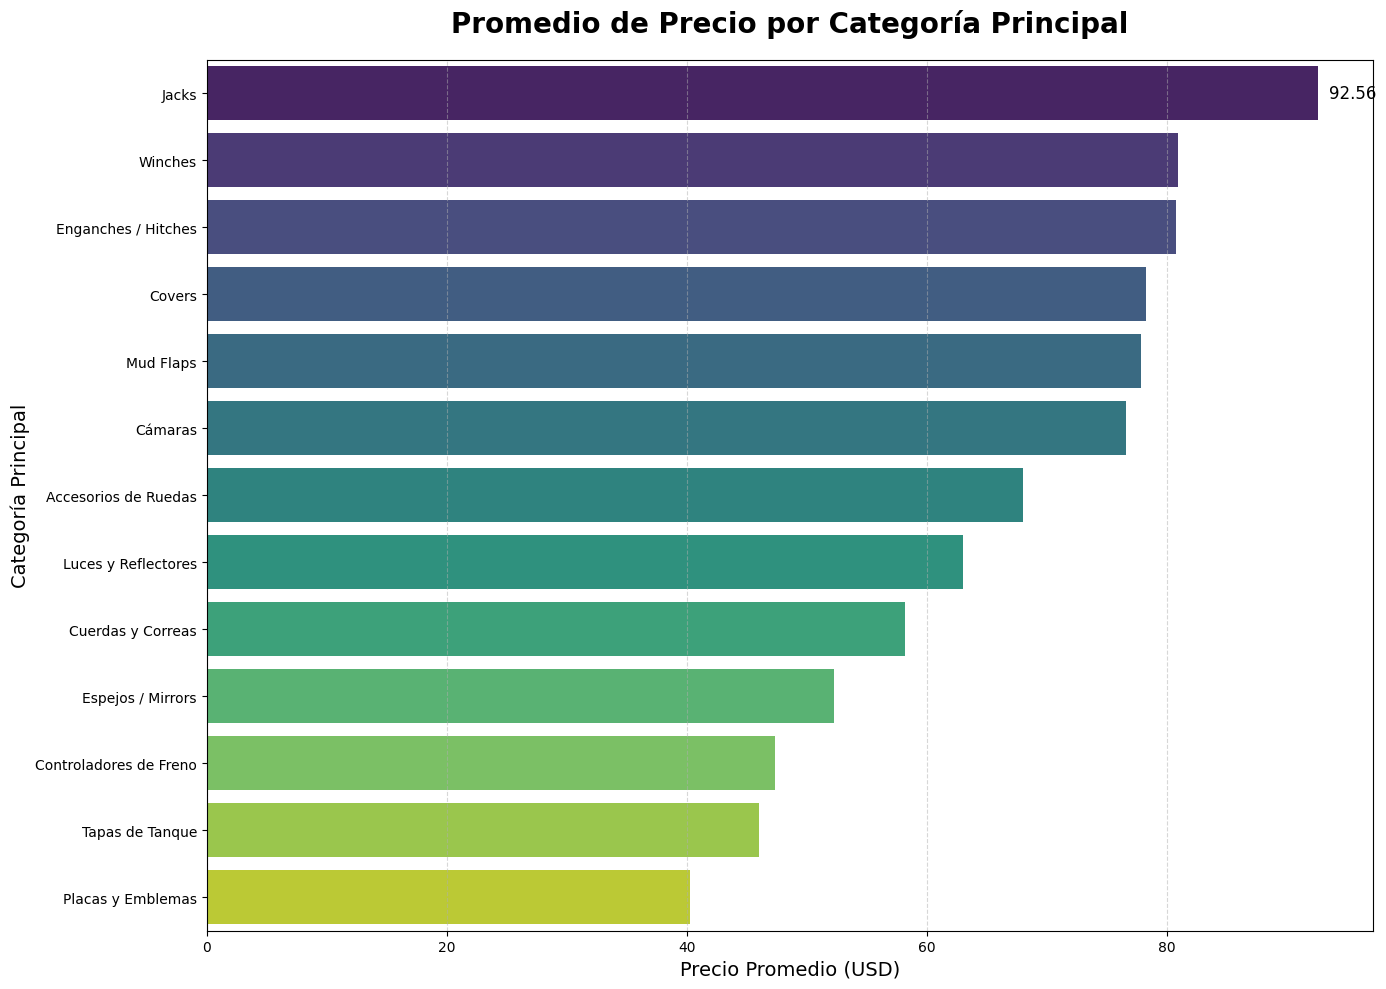

KPI 4 - Promedio de Precio por Categoría:
 Main_Category
Jacks                     92.56
Winches                   80.89
Enganches / Hitches       80.77
Covers                    78.30
Mud Flaps                 77.87
Cámaras                   76.61
Accesorios de Ruedas      68.02
Luces y Reflectores       63.01
Cuerdas y Correas         58.17
Espejos / Mirrors         52.28
Controladores de Freno    47.31
Tapas de Tanque           46.02
Placas y Emblemas         40.31
Name: Price_USD, dtype: float64


In [21]:
#Calculo
avg_price_category = df.groupby('Main_Category')['Price_USD'].mean().sort_values(ascending=False)
#Grafico
plt.figure(figsize=(14, 10))
sns.barplot(x=avg_price_category.values, y=avg_price_category.index, palette='viridis')
plt.title('Promedio de Precio por Categoría Principal', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Precio Promedio (USD)', fontsize=14)
plt.ylabel('Categoría Principal', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.bar_label(plt.gca().containers[0], fmt='%.2f', fontsize=12, padding=8, color='black')
plt.tight_layout()
plt.show()

print("KPI 4 - Promedio de Precio por Categoría:\n", avg_price_category.round(2))

5. Top 5 Marcas con Más Productos

- Descripción: Identifica líderes del mercado. Insight: CURT y Dorman dominan – analiza su monopolio.
- Cálculo: df['Brand'].value_counts().head(5)
- Ejemplo: CURT: ~800, Dorman: ~700, Husky: ~300.

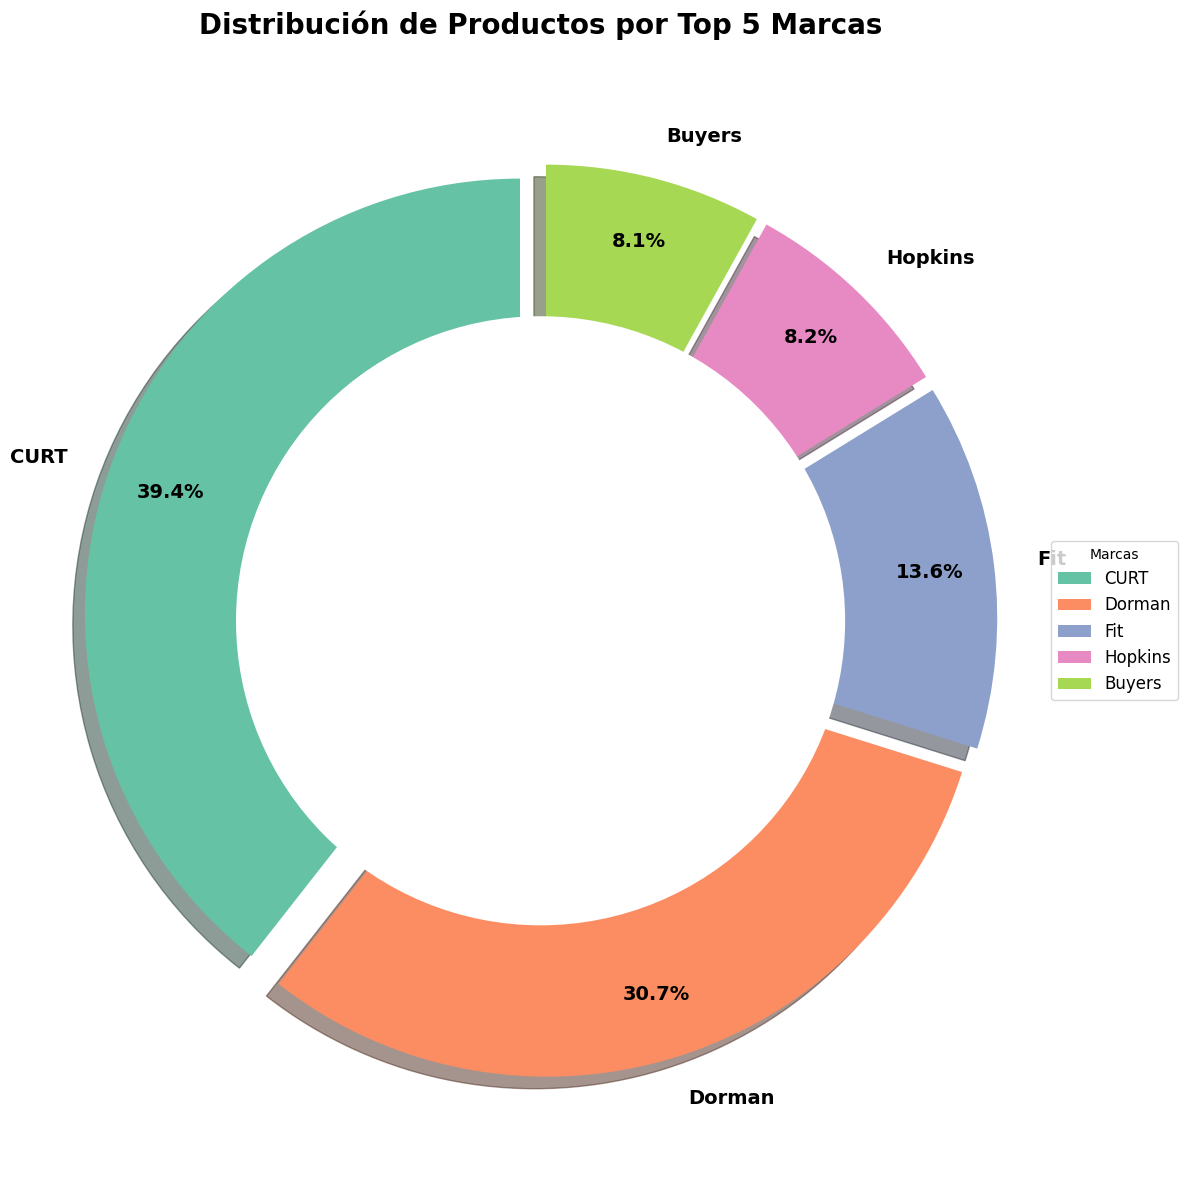

KPI 5 - Top 5 Marcas con Más Productos:
 Brand
CURT       1067
Dorman      832
Fit         369
Hopkins     221
Buyers      218
Name: count, dtype: int64


In [22]:
top_brands = df['Brand'].value_counts().head(5)

plt.figure(figsize=(12, 12))
wedges, texts, autotexts = plt.pie(
    top_brands,
    labels=top_brands.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette('Set2', len(top_brands)),
    explode=[0.05] * len(top_brands),
    shadow=True,
    textprops={'fontsize': 14, 'fontweight': 'bold'},
    pctdistance=0.85
)

# Círculo central para donut
centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Distribución de Productos por Top 5 Marcas', fontsize=20, fontweight='bold', pad=20)
plt.legend(wedges, top_brands.index, title="Marcas", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), fontsize=12)
plt.axis('equal')
plt.tight_layout()
plt.show()

print("KPI 5 - Top 5 Marcas con Más Productos:\n", top_brands)

6. Promedio de Reseñas por Marca (Top 10)

- Descripción: Mide reputación. Insight: Marcas con altas reseñas (Ampper >10k avg) son "virales" – enfócate en ellas para marketing.
- Cálculo: df.groupby('Brand')['Review_Count'].mean().sort_values(ascending=False).head(10)
- Ejemplo: Ampper: ~5000+, CURT: ~2000, Dorman: ~500.

/tmp/ipython-input-225192086.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_reviews_brand.values, y=avg_reviews_brand.index, palette='magma')


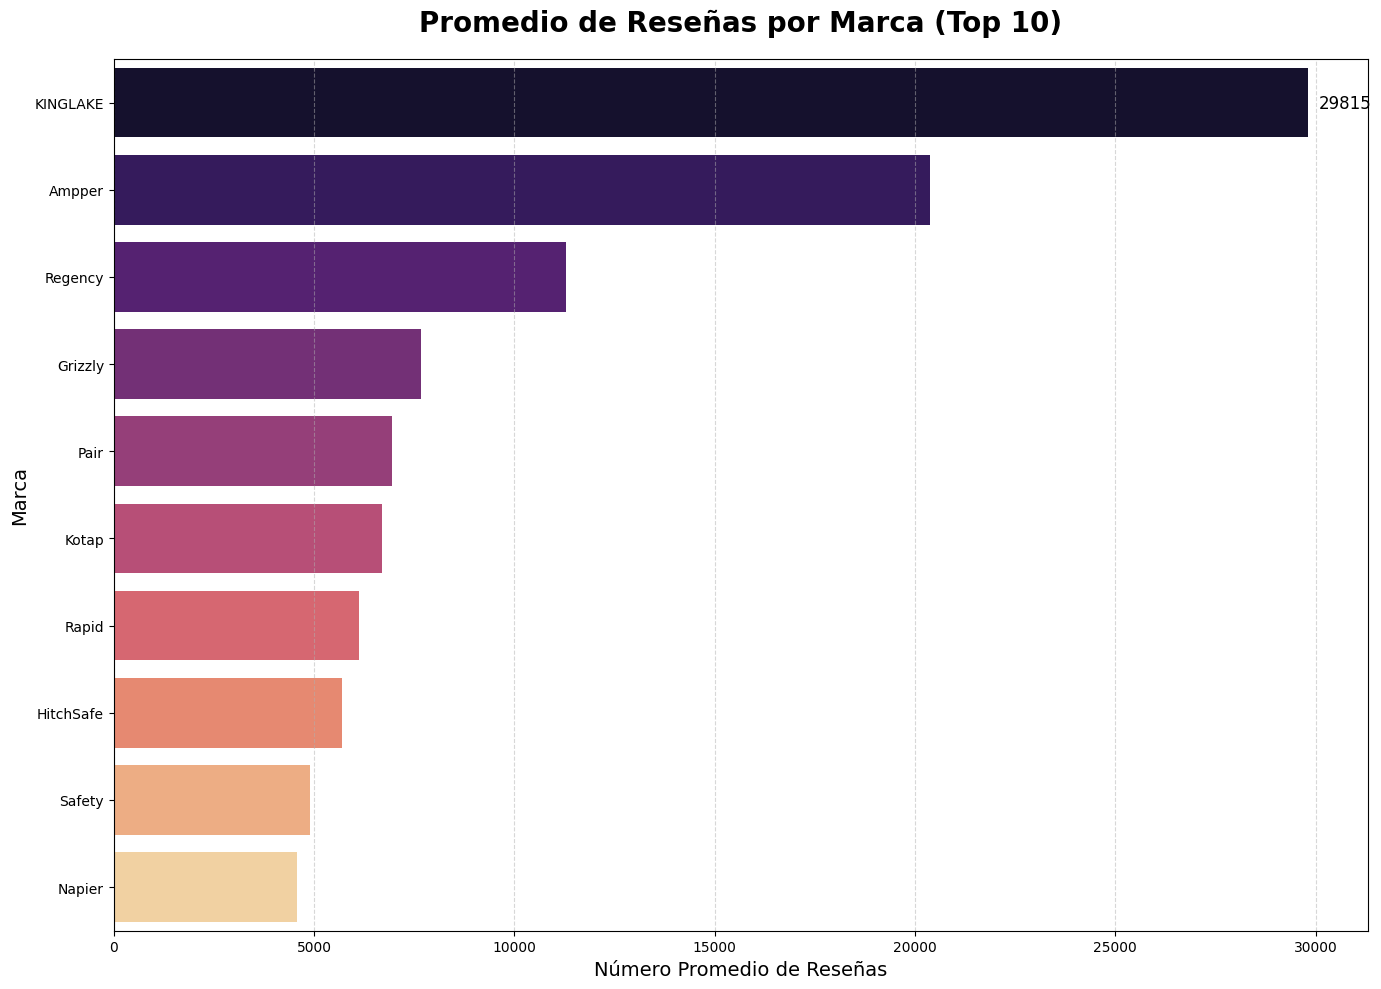

KPI 6 - Promedio de Reseñas por Marca (Top 10):
 Brand
KINGLAKE     29815
Ampper       20378
Regency      11292
Grizzly       7681
Pair          6957
Kotap         6694
Rapid         6121
HitchSafe     5696
Safety        4889
Napier        4575
Name: Review_Count, dtype: int64


In [23]:
avg_reviews_brand = df.groupby('Brand')['Review_Count'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(14, 10))
sns.barplot(x=avg_reviews_brand.values, y=avg_reviews_brand.index, palette='magma')
plt.title('Promedio de Reseñas por Marca (Top 10)', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Número Promedio de Reseñas', fontsize=14)
plt.ylabel('Marca', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.bar_label(plt.gca().containers[0], fmt='%.0f', fontsize=12, padding=8, color='black')
plt.tight_layout()
plt.show()

print("KPI 6 - Promedio de Reseñas por Marca (Top 10):\n", avg_reviews_brand.round(0).astype(int))

7. Porcentaje de Productos por Nivel de Popularidad

- Descripción: Muestra distribución de "éxito". Insight: Solo ~20% son "Alto" – ¿por qué los bajos no despegan?
- Cálculo: (df['Popularity_Level'].value_counts(normalize=True) * 100).round(2)
- Ejemplo: Bajo: ~50%, Medio: ~30%, Alto: ~20%.

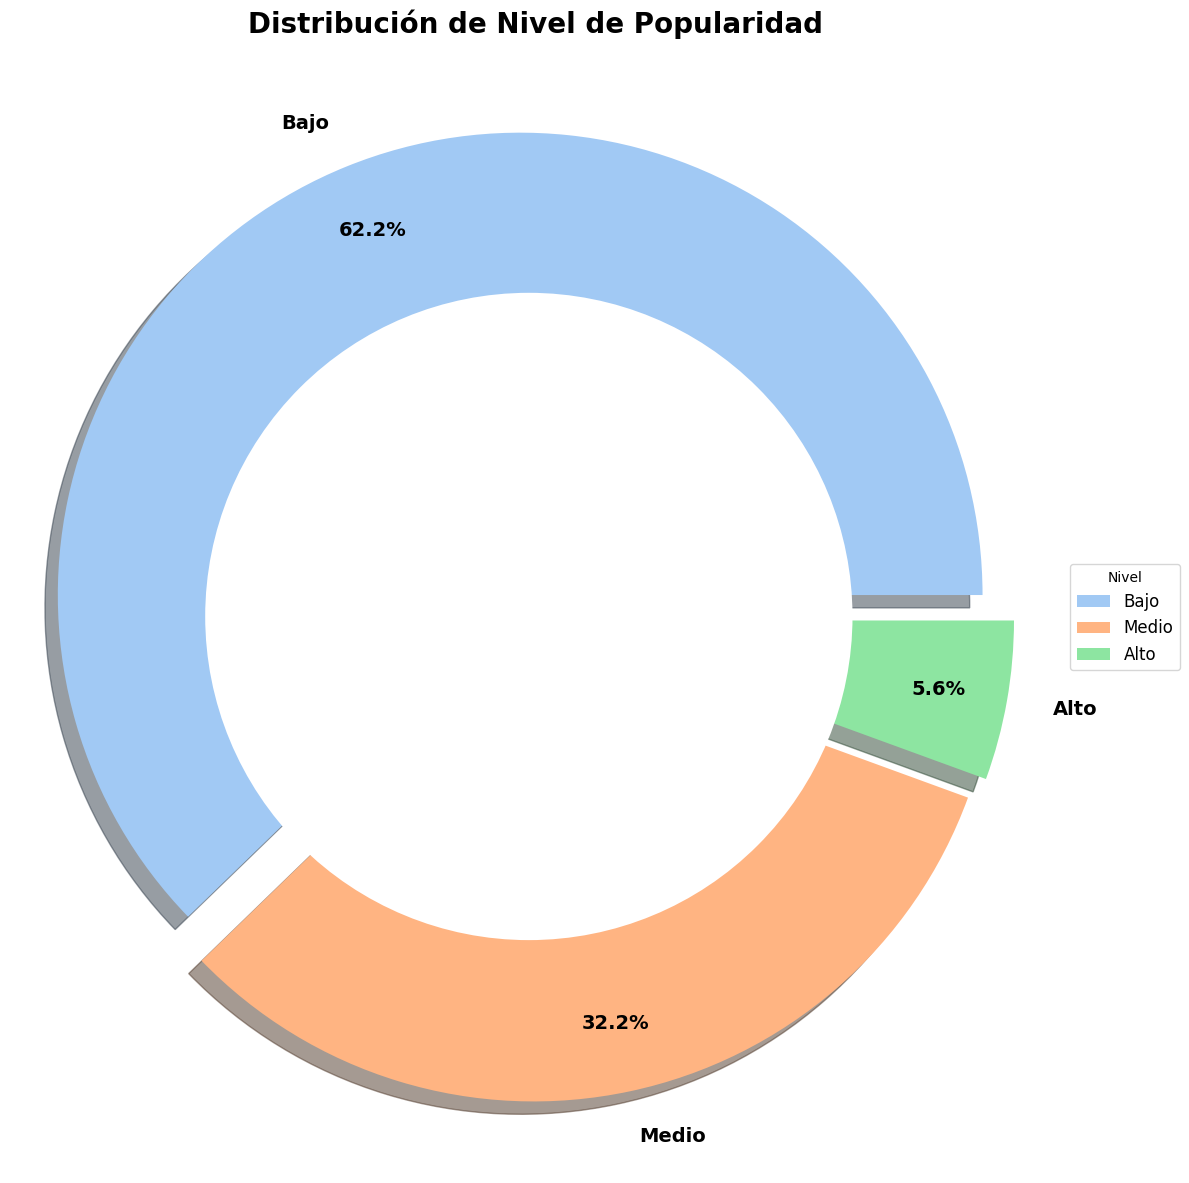

KPI 7 - Porcentaje por Nivel de Popularidad:
 Popularity_Level
Bajo     62.24
Medio    32.18
Alto      5.57
Name: proportion, dtype: float64


In [24]:
popularity_dist = (df['Popularity_Level'].value_counts(normalize=True) * 100).round(2)

plt.figure(figsize=(12, 12))
wedges, texts, autotexts = plt.pie(
    popularity_dist,
    labels=popularity_dist.index,
    autopct='%1.1f%%',
    colors=sns.color_palette('pastel'),
    explode=[0.05] * len(popularity_dist),
    shadow=True,
    textprops={'fontsize': 14, 'fontweight': 'bold'},
    pctdistance=0.85
)

centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Distribución de Nivel de Popularidad', fontsize=20, fontweight='bold', pad=20)
plt.legend(wedges, popularity_dist.index, title="Nivel", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), fontsize=12)
plt.axis('equal')
plt.tight_layout()
plt.show()

print("KPI 7 - Porcentaje por Nivel de Popularidad:\n", popularity_dist)

8. Índice de Valor por Dinero (Reseñas por Dólar)

- Descripción: Métrica derivada: ¿Cuántas reseñas "compra" cada dólar? Insight: Productos baratos con altas reseñas (ej: espejos ~500 reseñas/) son bargains – recomiendalos.
- Cálculo: df['Value_Score'] = df['Review_Count'] / (df['Price_USD'] + 1)  # +1 evita división por cero; luego promedio por categoría.
- Ejemplo: Espejos: ~200 reseñas/$, Winches: ~10 (bajo valor relativo).
cual es el pru¿oducto mas vendido por unidad

In [25]:
df['Value_Score'] = df['Review_Count'] / (df['Price_USD'] + 1)
avg_value_category = df.groupby('Main_Category')['Value_Score'].mean().sort_values(ascending=False)
print("Índice de Valor por Dinero por Categoría:\n", avg_value_category)

Índice de Valor por Dinero por Categoría:
 Main_Category
Tapas de Tanque           35.674052
Cuerdas y Correas         33.746732
Luces y Reflectores       26.205509
Placas y Emblemas         20.783128
Jacks                     19.483390
Covers                    17.236828
Enganches / Hitches       14.959488
Cámaras                   14.491225
Controladores de Freno    13.219613
Mud Flaps                 12.675401
Winches                   12.328653
Accesorios de Ruedas       9.827107
Espejos / Mirrors          7.863409
Name: Value_Score, dtype: float64


9. Porcentaje de Productos Universales vs Específicos

- Descripción: Analiza compatibilidad. Insight: ~45% universales – mercado amplio, pero nicho (Jeep/Ford) tiene más reseñas leales.
- Cálculo: (df['Vehicle_Compatibility'].value_counts(normalize=True) * 100).round(2).head(5)
- Ejemplo: Universal: ~45%, No Especificado: ~10%, Jeep: ~12%.

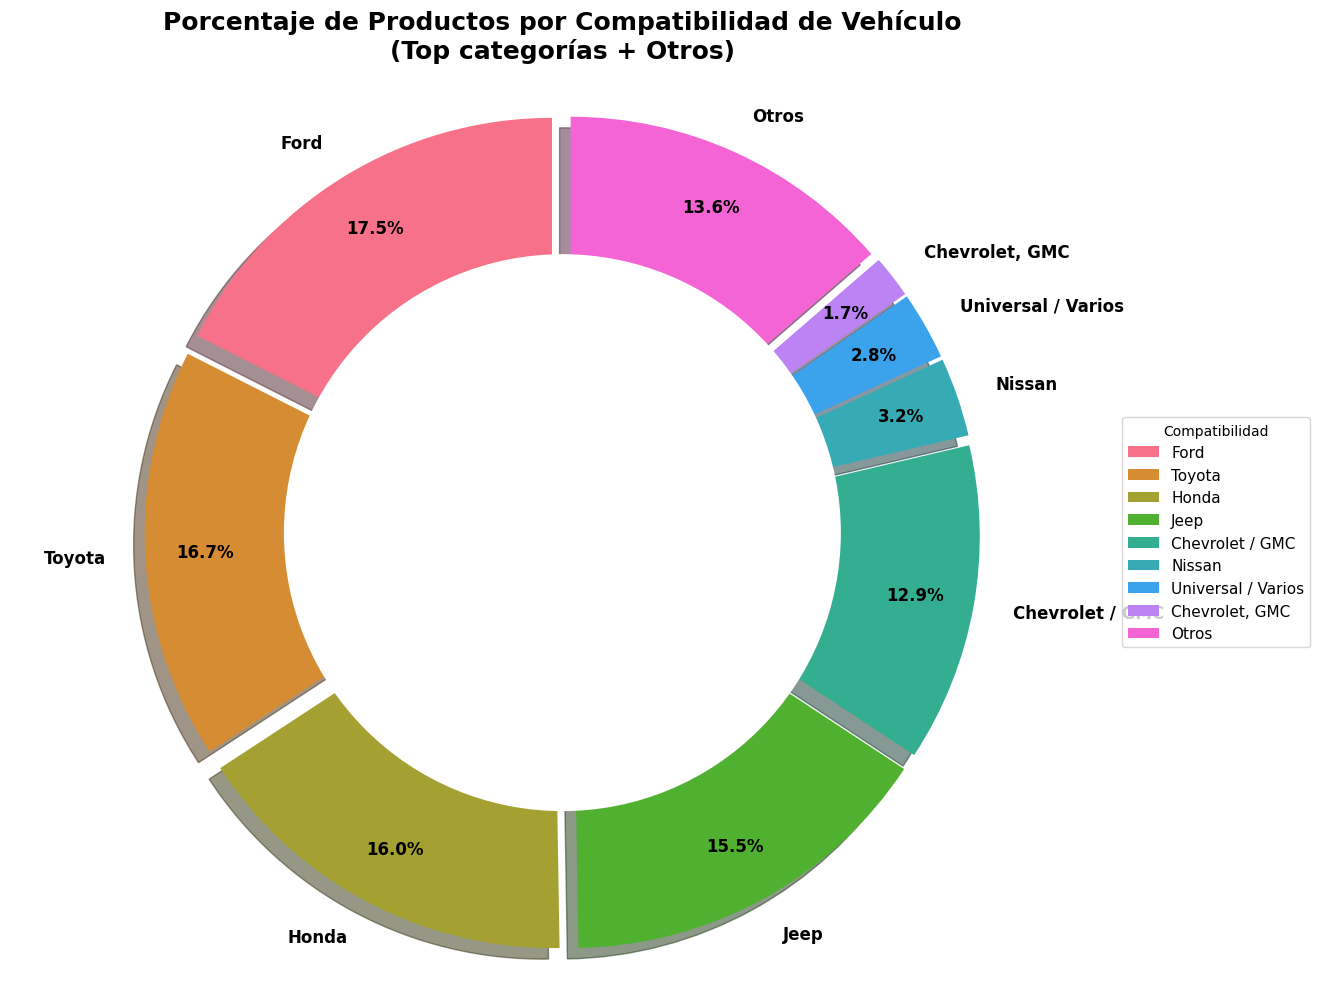

KPI 9 - Porcentaje de Productos por Compatibilidad de Vehículo:

Vehicle_Compatibility
Ford                  17.51
Toyota                16.68
Honda                 16.02
Jeep                  15.45
Otros                 13.62
Chevrolet / GMC       12.93
Nissan                 3.20
Universal / Varios     2.76
Chevrolet, GMC         1.73
Name: proportion, dtype: float64


In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Asegúrate de que df ya esté cargado
# Si no, carga tu CSV primero:
# df = pd.read_csv('amazon_car_accessories_final.csv')

# Cálculo del KPI 9
compat_dist = (df['Vehicle_Compatibility'].value_counts(normalize=True) * 100).round(2)

# Para que el pastel no tenga demasiadas porciones, agrupamos las menores en "Otros"
top_n = 8  # Puedes cambiar a 10 si quieres más detalle
top_compat = compat_dist.head(top_n)
otros = compat_dist.iloc[top_n:].sum()  # Suma el resto
if otros > 0:
    top_compat['Otros'] = otros

# Gráfico bien hecho
plt.figure(figsize=(12, 10))  # Tamaño grande para que se vea claro
colors = sns.color_palette('husl', len(top_compat))  # Paleta bonita y variada
explode = [0.05] * len(top_compat)  # Pequeño "explosion" para destacar

wedges, texts, autotexts = plt.pie(
    top_compat,
    labels=top_compat.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    explode=explode,
    shadow=True,
    textprops={'fontsize': 12, 'fontweight': 'bold'},
    pctdistance=0.85
)

# Añade un círculo blanco en el centro para que sea un "donut" más moderno
centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Porcentaje de Productos por Compatibilidad de Vehículo\n(Top categorías + Otros)',
          fontsize=18, fontweight='bold', pad=20)
plt.axis('equal')  # Para que sea un círculo perfecto
plt.tight_layout()

# Leyenda a la derecha para no tapar el pastel
plt.legend(wedges, top_compat.index, title="Compatibilidad",
           loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), fontsize=11)

plt.show()

# Imprime el valor numérico para tu informe
print("KPI 9 - Porcentaje de Productos por Compatibilidad de Vehículo:\n")
print(top_compat.sort_values(ascending=False))

10. Número de Productos Caros con Alta Popularidad

- Descripción: Cruza rangos: ¿Cuántos productos >$50 tienen ≥1000 reseñas? Insight: Solo ~5-10% – nicho premium rentable.
- Cálculo: len(df[(df['Price_Range'] == 'Caro') & (df['Popularity_Level'] == 'Alto')])
- Ejemplo: ~200 productos (oportunidad para inversión).

Número de Productos Caros con Alta Popularidad: 136
Número de Productos Caros con Alta Popularidad: 136

Top 10 Productos Premium Exitosos (Caros + ≥1000 reseñas):
                                          Product_Title      Brand  Price_USD  \
3035  Bully BBS-1103 Truck Black Powder Coated Side ...      Bully       61.0   
3003  MaxxHaul 70115 46" x 36" x 4-1/2" Roof Rack Ro...   MaxxHaul      129.0   
106   Pro-Lift F-767 Grey Low Profile Floor Jack - 2...       Lift       88.0   
847   Tekonsha 90160 Primus IQ Electronic Brake Control   Tekonsha       90.0   
1973  Tekonsha 90195 P3 Electronic Brake Control , s...   Tekonsha      137.0   
3450  Tyger Auto T1 Soft Roll-up Truck Bed Tonneau C...      Tyger       80.0   
3999  CURT 56120 Vehicle-Side Custom 4-Pin Trailer W...       CURT       54.0   
3020  Pro-Lift Heavy Duty 6 Ton Jack Stands Pair - D...       Lift       54.0   
3053  HitchSafe HS7000 Key Vault, Black | Hidden Sto...  HitchSafe       75.0   
3034  Powerbuilt Heavy Dut

/tmp/ipython-input-194132351.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-194132351.py:41: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


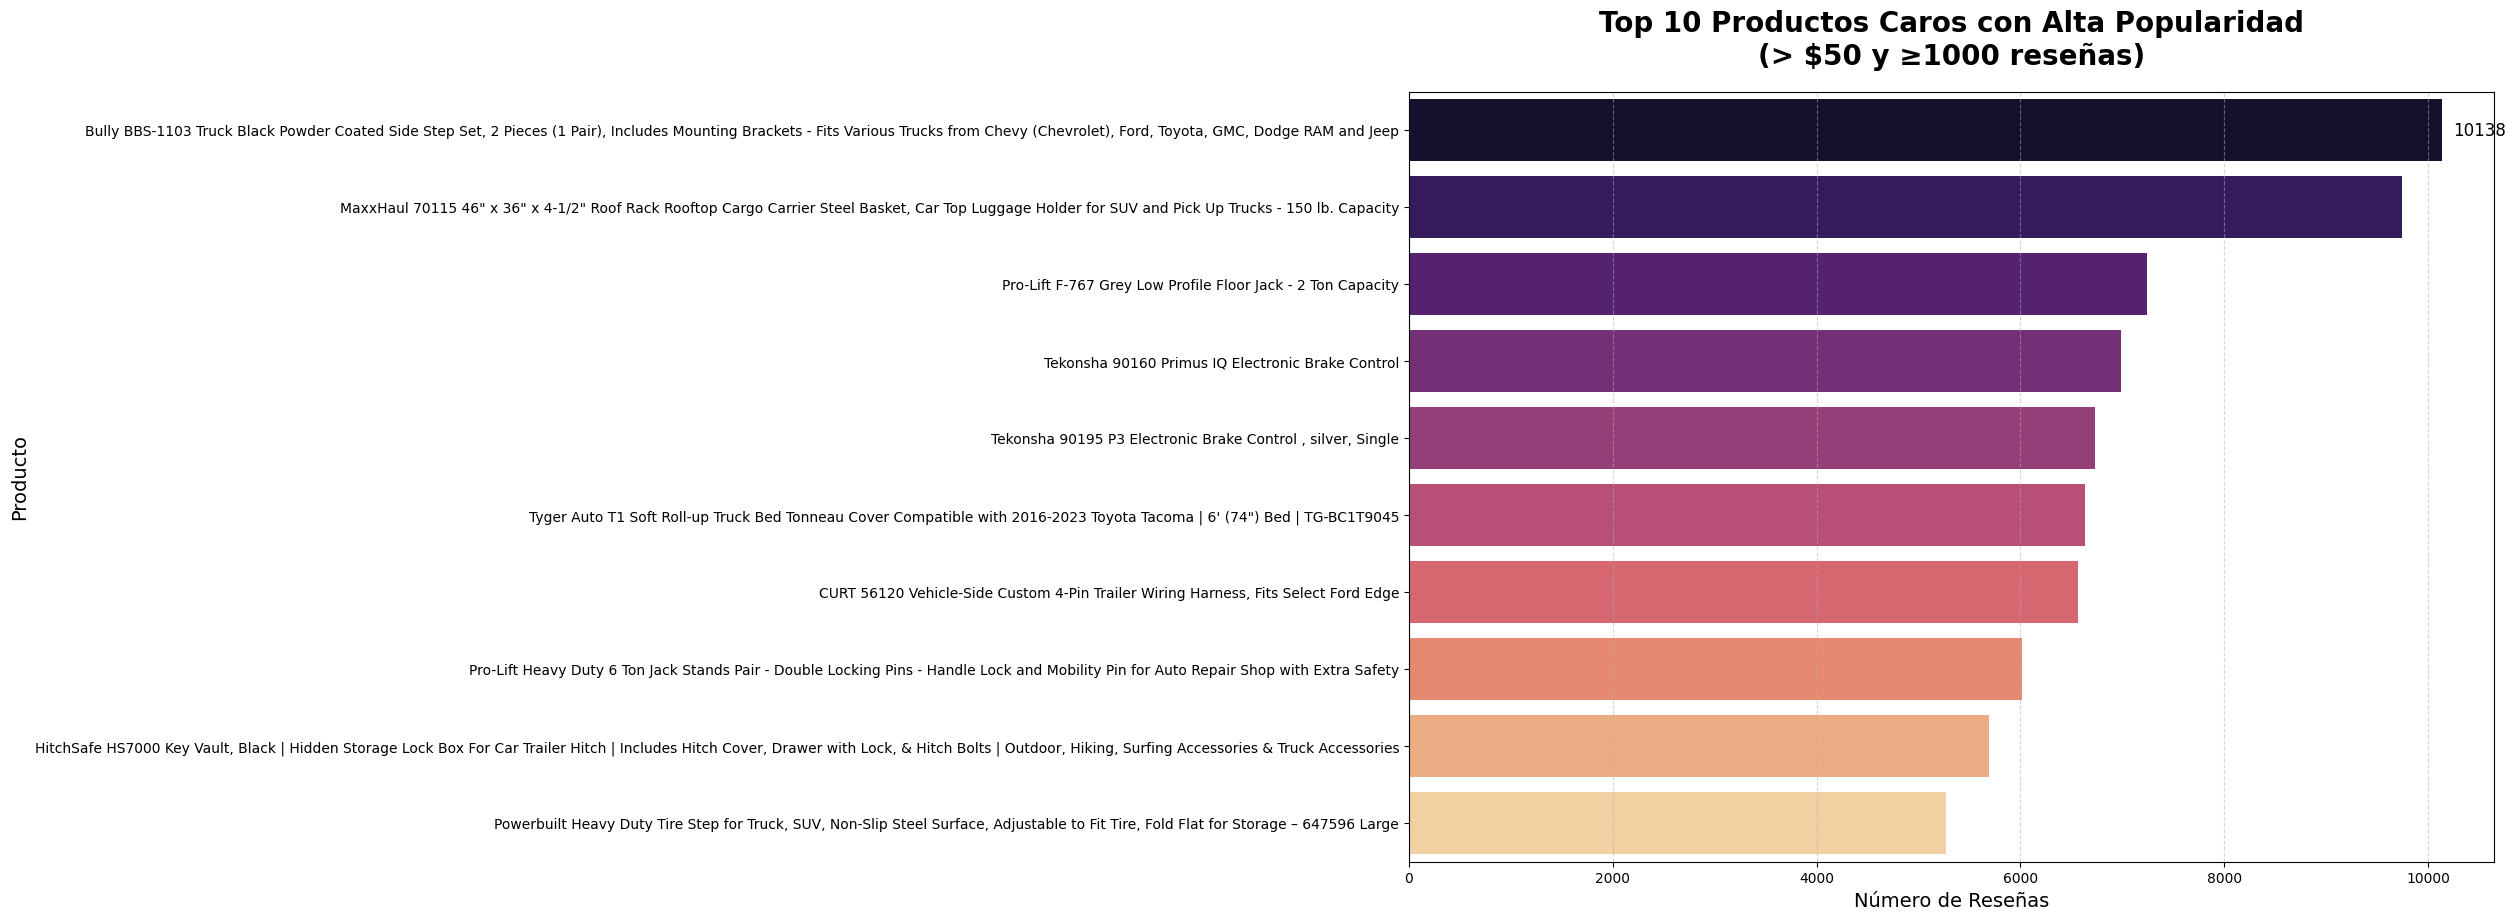

In [27]:
high_value_premium = len(df[(df['Price_Range'] == 'Caro') & (df['Popularity_Level'] == 'Alto')])
print(f"Número de Productos Caros con Alta Popularidad: {high_value_premium}")

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrar productos Caro + Alta Popularidad
premium_success = df[(df['Price_Range'] == 'Caro') & (df['Popularity_Level'] == 'Alto')]

# Conteo total (el número que tenías antes)
total_premium_success = len(premium_success)
print(f"Número de Productos Caros con Alta Popularidad: {total_premium_success}")

# Top 10 por número de reseñas (los más exitosos)
top_premium = premium_success.sort_values('Review_Count', ascending=False).head(10)

# Mostrar tabla clara
print("\nTop 10 Productos Premium Exitosos (Caros + ≥1000 reseñas):")
print(top_premium[['Product_Title', 'Brand', 'Price_USD', 'Review_Count', 'Main_Category', 'Vehicle_Compatibility']])

# Gráfico: Barras horizontales de los top 10 por reseñas
plt.figure(figsize=(14, 10))
sns.barplot(
    x='Review_Count',
    y='Product_Title',
    data=top_premium,
    palette='magma'
)
plt.title('Top 10 Productos Caros con Alta Popularidad\n(> $50 y ≥1000 reseñas)',
          fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Número de Reseñas', fontsize=14)
plt.ylabel('Producto', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Etiquetas en las barras
plt.bar_label(plt.gca().containers[0], fmt='%d', fontsize=12, padding=8, color='black')

# Ajuste para que los títulos largos no se corten
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [28]:
df = pd.read_csv('Amazon_Car_Accessories_with_Rating.csv')
df

FileNotFoundError: [Errno 2] No such file or directory: 'Amazon_Car_Accessories_with_Rating.csv'

In [ ]:
# Cambiar el nombre de la columna 'Real price' a 'Delivery price'
df = df.rename(columns={'Real price': 'Delivery price'})

df

In [ ]:
df.to_csv('Datos.csv', index=False)